# Import library

In [38]:
import numpy as np
from keras.preprocessing import image
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
print("Files imported successfully")
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)
import os
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # Hiển thị tiến trình load ảnh
import shutil
import random
from collections import Counter
from IPython.display import clear_output

Files imported successfully


# Chia dữ liệu

In [ ]:
# Định nghĩa đường dẫn gốc
base_dir = "H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")  # Thư mục validation

# Tạo thư mục train, test, val nếu chưa có
for folder in [train_dir, test_dir, val_dir]:
    os.makedirs(os.path.join(folder, "Cat"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Dog"), exist_ok=True)

# Chia dữ liệu theo tỉ lệ 80-10-10
def split_data(class_name):
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    total_images = len(images)
    train_split = int(total_images * 0.8)  # 80% cho train
    test_split = int(total_images * 0.9)  # 10% tiếp theo cho test, 10% còn lại cho val

    train_images = images[:train_split]
    test_images = images[train_split:test_split]
    val_images = images[test_split:]

    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))

    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(test_dir, class_name, img))

    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(val_dir, class_name, img))

split_data("Cat")
split_data("Dog")

print("✅ Chia dữ liệu thành công! Tập train, test, và val đã được tạo.")


✅ Chia dữ liệu thành công! Tập train, test, và val đã được tạo.


# Đọc ảnh

In [33]:
# Kích thước ảnh sau khi resize
IMG_SIZE = 50  

def load_images_from_folder(folder):
    """ Đọc ảnh từ thư mục và trả về numpy array """
    data = []
    labels = []
    
    for class_name in ["Cat", "Dog"]:
        class_path = os.path.join(folder, class_name)
        label = 0 if class_name == "Cat" else 1  # Gán nhãn 0 cho mèo, 1 cho chó
        
        for img_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name} from {folder}"):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize ảnh về (50x50)
                img = img / 255.0  # Chuẩn hóa pixel về [0,1]
                img = np.expand_dims(img, axis=-1)  # Thêm 1 kênh để có dạng (50, 50, 1)
                data.append(img)
                labels.append(label)
            except:
                continue  # Bỏ qua ảnh lỗi

    return np.array(data), np.array(labels)

# Load dữ liệu từ thư mục
X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)
X_val, y_val = load_images_from_folder(val_dir)

# In kích thước ban đầu
print(f"📌 X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"📌 X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"📌 X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Reshape ảnh thành vector (N, 2500)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# In kích thước sau khi reshape
print(f"📌 X_train (reshaped) shape: {X_train_flat.shape}")
print(f"📌 X_test (reshaped) shape: {X_test_flat.shape}")
print(f"📌 X_val (reshaped) shape: {X_val_flat.shape}")

Loading Cat from H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages\train: 100%|██████████| 9992/9992 [00:45<00:00, 217.61it/s]
Loading Dog from H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages\train: 100%|██████████| 9976/9976 [00:30<00:00, 322.38it/s]
Loading Cat from H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages\test: 100%|██████████| 1249/1249 [00:02<00:00, 559.93it/s]
Loading Dog from H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages\test: 100%|██████████| 1247/1247 [00:01<00:00, 1181.10it/s]
Loading Cat from H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages\val: 100%|██████████| 1250/1250 [00:00<00:00, 1343.33it/s]
Loading Dog from H:\ComputerVisionSchoolCourse\KNN\kagglecatsanddogs_3367a\PetImages\val: 100%|██████████| 1247/1247 [00:01<00:00, 1189.87it/s]

📌 X_train shape: (19930, 50, 50, 1), y_train shape: (19930,)
📌 X_test shape: (2490, 50, 50, 1), y_test shape: (2490,)
📌 X_val shape: (2493, 50, 50, 1), y_val shape: (2493,)
📌 X_train (reshaped) shape: (19930, 2500)
📌 X_test (reshaped) shape: (2490, 2500)
📌 X_val (reshaped) shape: (2493, 2500)


# Define KNN

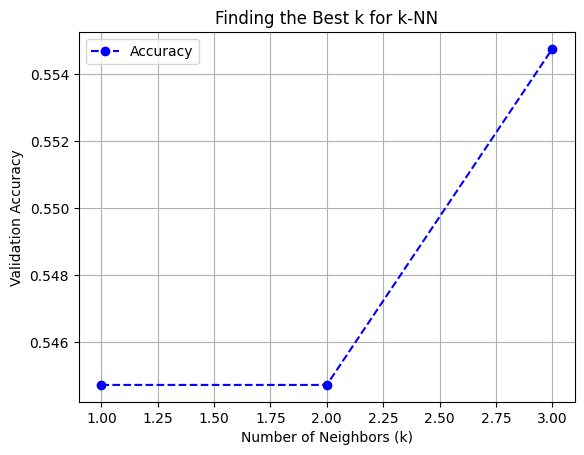

Finding best k:  15%|█▌        | 3/20 [42:37<4:06:20, 869.46s/it]

✅ k = 3, Accuracy = 55.48%


In [ ]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        return np.array([self._predict_single(x) for x in X_test])

    def _predict_single(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Giả sử bạn đã có X_train_flat, X_val_flat, y_train, y_val từ bước tiền xử lý ảnh
k_values = range(1, 21)
accuracies = []

plt.figure(figsize=(8, 5))
for k in tqdm(k_values, desc="Finding best k"):
    knn = KNNClassifier(k=k)
    knn.fit(X_train_flat, y_train)
    y_pred = knn.predict(X_val_flat)
    accuracy = np.mean(y_pred == y_val)
    accuracies.append(accuracy)

    # Cập nhật kết quả ngay trên notebook
    clear_output(wait=True)
    plt.clf()
    plt.plot(k_values[: len(accuracies)], accuracies, marker="o", linestyle="dashed", color="b", label="Accuracy")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Validation Accuracy")
    plt.title("Finding the Best k for k-NN")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"✅ k = {k}, Accuracy = {accuracy:.2%}")

# Chọn k tốt nhất
best_k = k_values[np.argmax(accuracies)]
print(f"\n🔍 Best k found: {best_k} with accuracy {max(accuracies):.2%}")